## Problem
Kredi riski sınıflandırmak üzere bir makine öğrenmesi modeli kurmak.

**Değişkenler**

* Age: Yaş
* Sex: Cinsiyet
* Job: Meslek-Yetenek (0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
* Housing: Barınma Durumu (own, rent, or free)
* Saving accounts: Tasarruf Durumu (little, moderate, quite rich, rich)
* Checking account: Vadesiz Hesap (DM - Deutsch Mark)
* Credit amount: Kredi Miktarı (DM)
* Duration: Süre (month)
* Purpose: Amaç (car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)
* Risk: Risk (Good, Bad Risk)

In [1]:
!pip install lightgbm

# LightGBM, histogram tabanlı çalışan bir algoritmadır. Sürekli değere sahip olan değişkenleri kesikli(discrete bin) hale getirerek hesaplama maliyetini azaltır. 

In [2]:
!pip install xgboost 

# XGBoost, LightGBM algoritmaları ile daha hızlı eğitim ve daha yüksek doğruluk elde edilmesi amaçlanmıştır.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV

import missingno as msno

import warnings
warnings.filterwarnings("ignore")

%config InlineBackend.figure_format = 'retina'

import os
os.chdir(r"C:\Users\Excalibur\Desktop\VERİ BİLİMİ\KAGGLE\dataset")

**%config InlineBackend.figure_format = 'retina'**
* Sadece görüntülenen grafiğin tanımı biraz daha iyi: retina kalitesi. Retina çözünürlüğüne sahip herhangi bir ekran, rakamların daha iyi görünmesini sağlayacaktır - monitörünüzün çözünürlüğü retina altı ise, iyileştirme daha az fark edilir olacaktır.

**K-Fold Cross Validation**, sınıflandırma modellerinin değerlendirilmesi ve modelin eğitilmesi için veri setini parçalara ayırma yöntemlerinden biridir.

K-Fold, bir makine öğrenimi modelinin görünmeyen veriler üzerindeki becerisini tahmin etmek için kullanılan bir çapraz doğrulama yöntemidir. Genellikle bir modeli doğrulamak için kullanılır, çünkü anlaşılması, uygulanması kolaydır ve sonuçlar, normal Doğrulama Yöntemlerinden daha yüksek bir bilgilendirici değere sahiptir.

In [4]:
dff = pd.read_csv("german_credit_data.csv", index_col=0)

# index_col=0 parametresi veri setindeki fazladan olan "Unnamed: 0" index kolonunu kaldırdı.

dff.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [5]:
df = dff.copy()

In [6]:
df.shape

(1000, 10)

In [7]:
df.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

NaN değer nulunduran kolonlar ve toplam NaN değer sayıları
* Saving accounts     183
* Checking account    394

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


In [9]:
df.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


In [10]:
for i in df.columns:
    if df[i].nunique() <= 10:
        print(i,":")
        print(df[i].value_counts(),"\n")

Sex :
male      690
female    310
Name: Sex, dtype: int64 

Job :
2    630
1    200
3    148
0     22
Name: Job, dtype: int64 

Housing :
own     713
rent    179
free    108
Name: Housing, dtype: int64 

Saving accounts :
little        603
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64 

Checking account :
little      274
moderate    269
rich         63
Name: Checking account, dtype: int64 

Purpose :
car                    337
radio/TV               280
furniture/equipment    181
business                97
education               59
repairs                 22
domestic appliances     12
vacation/others         12
Name: Purpose, dtype: int64 

Risk :
good    700
bad     300
Name: Risk, dtype: int64 



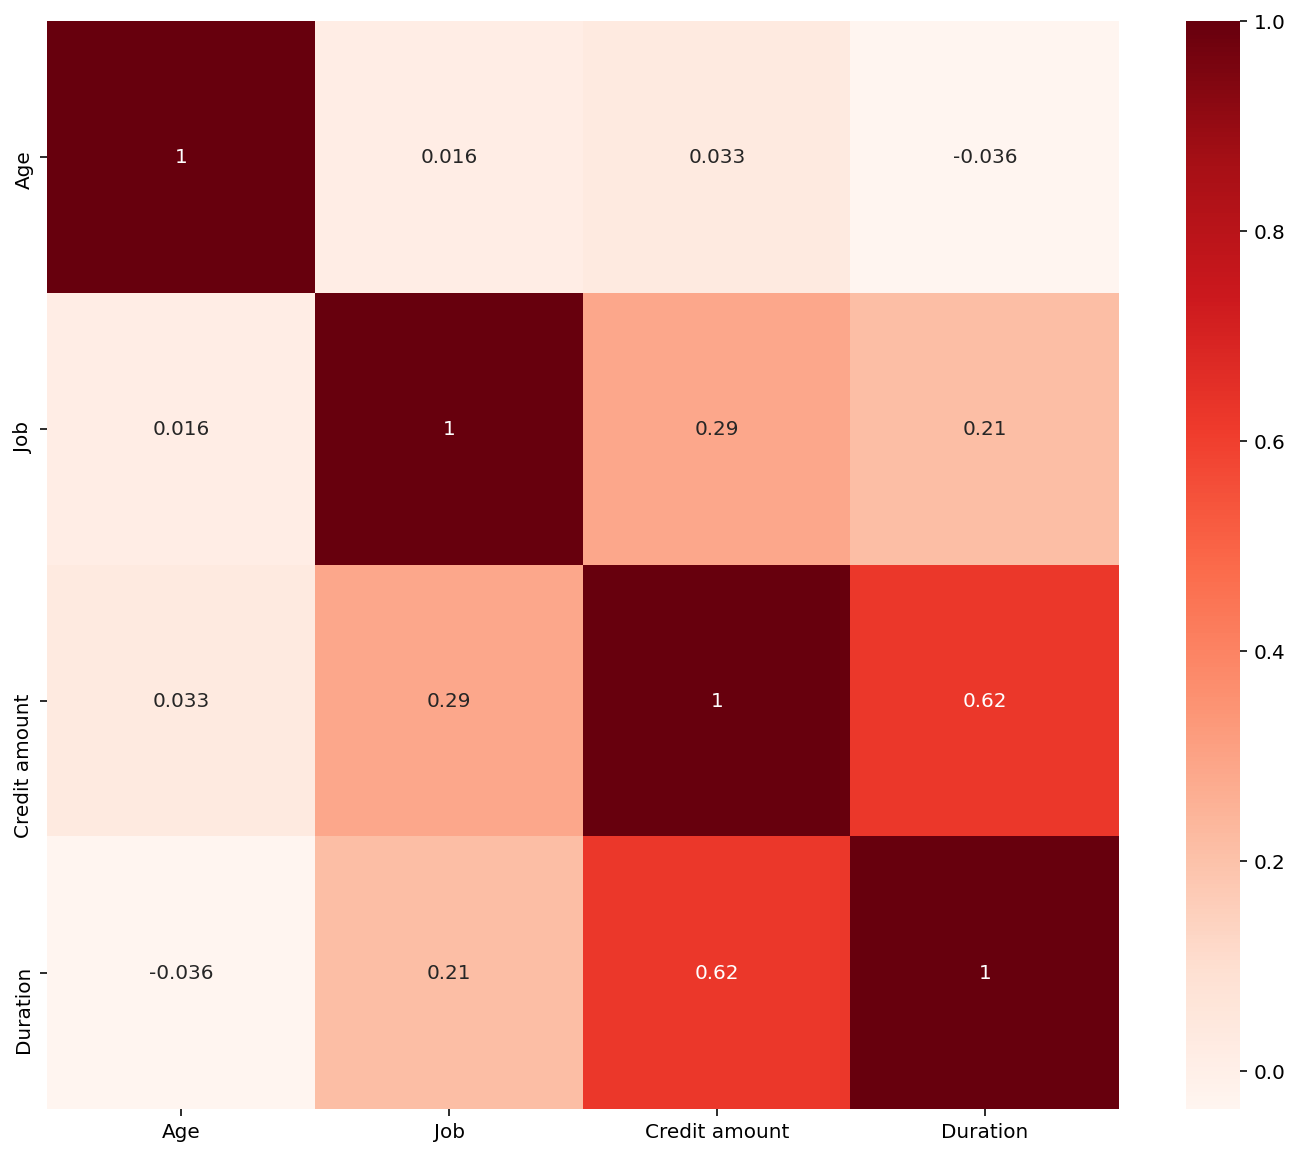

In [11]:
plt.figure(figsize=(12,10))
cor = df.corr()

sns.heatmap(cor, annot = True, cmap = plt.cm.Reds)
# annot = True : hücrelere veri değerlerini yazdırır.
# cmap (matplotlib colormap adı): Veri değerlerinden renk uzayına eşleme.

plt.show()

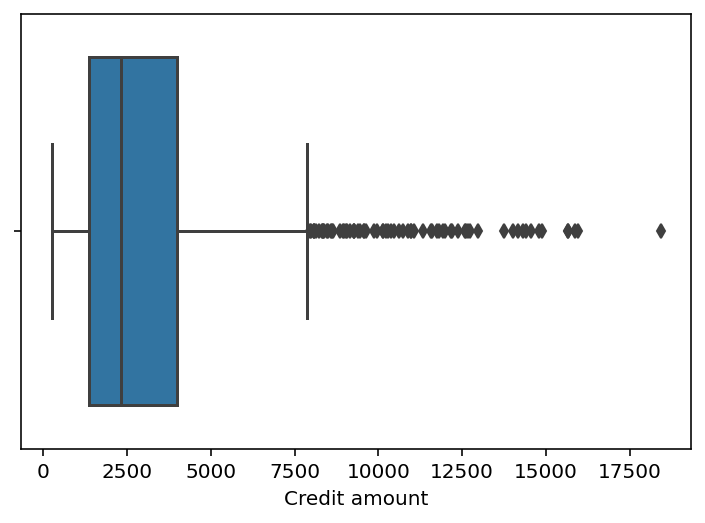

In [12]:
sns.boxplot(df["Credit amount"]);

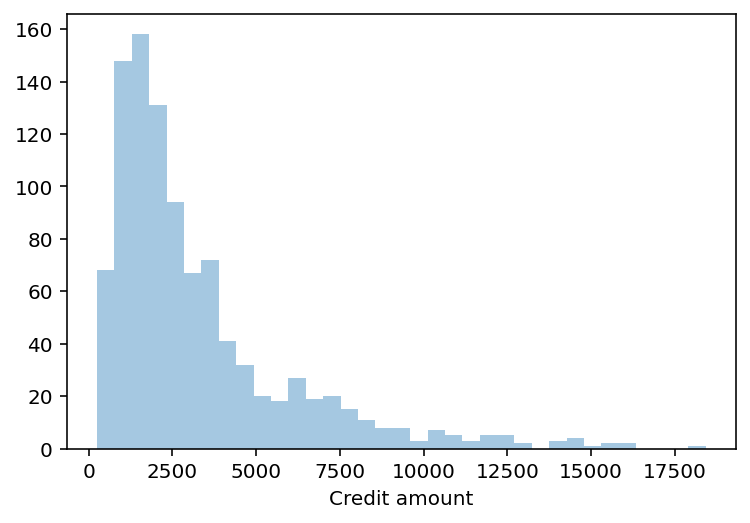

In [13]:
sns.distplot(df["Credit amount"], kde=False);

In [14]:
# Kullanacağımız fonksiyonalrı tanımladık.
low_q1 = 0.05
upper_q3 = 0.95

In [15]:
# KATEGORİ ÖZETİ
def cat_summary(df, cat_col, target, plot=False):
    """
    -> Kategorik değişkenlerin sınıflarının oranını ve targettaki medyanı gösterir.
   
    df : İşlem yapılacak dataframe
    cat_col : Kategorik değişkenlerin adları
    target: Dataframe'de ilgilendiğimiz(hedef) değişken.
    plot: Grafik çizdirmek için argüman : True/False
    """
    
    for col in cat_col:
        print(col,":", df[col].nunique(), " benzersiz sınıf bulunmaktadır.\n")
        print(col," sütununda ki gözlem sayısı ", df[col].value_counts().sum(), "\n")
        print(pd.DataFrame({"COUNT": df[col].value_counts(), 
                            "RATIO (%)": 100*df[col].value_counts() / len(df),
                            "TARGET_MEDIAN": df.groupby(col)[target].median(),
                            "TARGET_MEAN": df.groupby(col)[target].mean()}), end="\n\n\n")
        
        if plot:
            sns.countplot(x=col, data=df)
            plt.show()                        

In [16]:
# AYKIRI EŞİKLER
def outlier_thresholds(df, variable, low_quantile = low_q1, up_quantile = upper_q3):
    """
    -> Verilen değerin alt ve üst aykırı değerlerini hesaplar ve döndürür.

    df: İşlem yapılacak dataframe
    variable: Aykırı değeri yakalanacak değişkenin adı
    low_quantile: Alt eşik değerin hesaplanması için bakılan quantile değeri
    up_quantile: Üst eşik değerin hesaplanması için bakılan quantile değeri
    """
    
    Q1 = df[variable].quantile(low_quantile)
    Q3 = df[variable].quantile(up_quantile)
    IQR = Q3 - Q1
    
    low_limit = Q1 - 1.5 * IQR
    up_limit = Q3 + 1.5 * IQR
    
    return low_limit, up_limit

In [17]:
# AYKIRI DEĞERLER
def has_outliers(df, num_col, plot=False):
    """
    -> Sayısal değişkenlerde aykırı gözlem var mı?
    -> Varsa isteğe göre box plot çizdirme görevini yapar.
    -> Ayrıca aykırı gözleme sahip değişkenlerin ismini göndürür.

    df:  İşlem yapılacak dataframe
    num_col: Aykırı değerleri bakılacak sayısal değişken adları
    plot: Boxplot grafiğini çizdirmek için bool değer alır. True/False
    """
    variable_names = []
    
    for col in num_col:
        
        low_limit, up_limit = outlier_thresholds(df, col)
        
        if df[(df[col] > up_limit) | (df[col] < low_limit)].any(axis=None): # aykırı değer varsa
            
            number_of_outliers = df[(df[col] > up_limit) | (df[col] < low_limit)].shape[0] # aykırı gözlem sayısı
            
            print(col, ":", number_of_outliers, " aykırı gözlem bulunmaktadır.")
            
            variable_names.append(col)
            
            if plot:
                sns.boxplot(x = df[col])
                plt.show()
                
    return variable_names        

In [18]:
# AYKIRI VERİLERİ EŞİK DEĞERLER İLE BASKILAMA
def replace_with_thresholds(df, num_col):
    """
    -> Baskılama yöntemi
    -> Silmemenin en iyi alternatifidir.
    -> Loc kullanıldığından dataframe içinde işlemi uygular.

    df: İşlem yapılacak dataframe
    num_col: Aykırı değerleri baskılanacak sayısal değişkenlerin adları
    """
    
    for col in num_col:
        
        low_limit, up_limit = outlier_thresholds(df, col)
        
        df.loc[(df[col] < low_limit), col] = low_limit
        df.loc[(df[col] > up_limit), col] = up_limit

In [19]:
# EKSİK DEĞERLER TABLOSU
def missing_values_table(df):
    # Eksik değerlere sahip değişkenleri gösterir ve bu değerleri döndürür.
    
    variables_with_na = [col for col in df.columns if df[col].isnull().sum() > 0] # Boş değer bulunduran kolonlar
    
    n_miss = df[variables_with_na].isnull().sum().sort_values(ascending=False)
    
    ratio = (df[variables_with_na].isnull().sum()/df.shape[0]*100).sort_values(ascending=False)
    
    missing_df = pd.concat([n_miss, np.round(ratio,2)], axis=1, keys=["n_miss","ratio"])
    
    print(missing_df)
    
    return variables_with_na

In [20]:
# EKSİK DEĞERLİ DEĞİŞKENLER VE HEDEF DEĞİŞKEN İLİŞKİSİ
def missing_vs_target(df, target, variable_with_na):
    """
    Bu fonksiyon, eksik değerlere sahip değişkenlerin target açısından etkisine bakmamızı sağlar.
    Yeni bir değişken oluşturur : incelenen değer + _NA_FLAG
    Bu yeni değişkene, incelenen değişkende eksik gördüğünde 1, eksik yoksa 0 değerlerini atar.
    Daha sonra bu değişkenlere göre gruplama yapıp, target incelenir.

    df: İşlem yapılacak dataframe
    target: Analizi yapılacak hedef değişkenin adı
    variable_with_na: Eksik değerlere sahip değişkenlerin adı.
    """
    
    temp_df = df.copy()
    
    for col in variable_with_na:
        
        temp_df[col + "_NA_FLAG"] = np.where(temp_df[col].isnull(), 1, 0) # değişkende eksik değer varsa 1 yoksa 0 verilerini aldığı yeni bir colon oluşturuyoruz.
    
    flags_na = temp_df.loc[:, temp_df.columns.str.contains("_NA_").columns] # temp_df veri setin de "_NA_" geçen kolonları tutar.
    
    for col in flags_na:
        print(pd.DataFrame({"TARGET_MEDIAN":temp_df.groupby(col)[target].median()}), end="\n\n\n")
        

In [21]:
#  KATEGORİK DEĞİŞKENİ NUMERİK YAPMA
def label_encoder(df, cat_col):
    """
    -> 2 sınıflı kategorik değişkeni 0-1 yapma

    df: İşlem yapılacak dataframe
    cat_col: Label encode yapılacak kategorik değişken adları
    """
    
    le = preprocessing.LabelEncoder()
    
    for col in cat_col:
        
        if df[col].nunique() == 2:
            
            df[col] = le.fit_transform(df[col])
            
    return df

In [22]:
# ONE HOT ENCODER
def one_hot_encoder(df, cat_col, nan_as_cat=False):
    """
    -> Drop_first doğrusal modellerde yapılması gerekli
    -> Ağaç modellerde gerekli değil ama yapılabilir.
    -> dummy_na eksik değerlerden değişken türettirir.

    df: İşlem yapılacak dataframe
    cat_col: One-Hot Encode uygulanacak kategorik değişken adları
    nan_as_cat: NaN değişken oluştursun mu? True/False
    """
    original_columns = list(df.columns)
    
    df = pd.get_dummies(df, 
                        columns = cat_col, 
                        dummy_na = nan_as_cat, 
                        drop_first = False)
    new_columns =[col for col in df.columns if col not in original_columns]
    
    return df, new_columns # One-Hot Encode yapılmış dataframe ve bu işlem sonrası oluşan yeni değişken adlarını döndürür.
    

In [23]:
# Verilen eşik değerden düşük frekansa sahipse bu değişkenleri bulalım.
def rare_analyser(df, cat_col, target, rare_perc):
    """
    -> Data frame değişkenlerinin herhangi bir sınıfı, verilen eşik değerden düşük frekansa sahipse bu değişkenleri gösterir.

    df: İşlem yapılacak dataframe
    cat_col: Rare analizi yapılacak kategorik değişken adları
    target: Analizi yapılacak hedef değişken adı
    rare_perc: Rare için sınır değer. Altında olanlar rare kategorisine girer.
    """
    
    rare_col = [col for col in cat_col if (df[col].value_counts()/ len(df) < rare_perc).any(axis=None)] # len(df) = 1000 (Gözlem sayıs)
    
    for col in rare_col:
        
        # print(col,":",len(df[col].value_counts()))
        print(col,":", df[col].nunique(), " benzersiz sınıf bulunmaktadır.")
        
        print(pd.DataFrame({"COUNT": df[col].value_counts(),
                            "RATIO": df[col].value_counts() / len(df),
                            "TARGET_MEAN": df.groupby(col)[target].mean(),
                            "TARGET_MEDIAN": df.groupby(col)[target].median()}), end="\n\n\n")
        
    print(len(rare_col), " tane rare sınıfa sahip değişken bulunmaktadır.")

In [24]:
# SAĞLAM ÖLÇEKLEYİCİ - ROBUST SCALER
def robust_scaler(variable):
    
    var_median = variable.median()
    
    q1 = variable.quantile(0.01)
    q3 = variable.quantile(0.99)
    iqr = q3 - q1
    
    if int(iqr) == 0:
        q1 = variable.quantile(0.05)
        q3 = variable.quantile(0.95)
        iqr = q3 - q1
        
        if int(iqr) == 0:
            q1 = variable.quantile(0.25)
            q3 = variable.quantile(0.75)
            iqr = q3 - q1
            
            z = (variable - var_median) / iqr
            return round(z, 3)
        
        z = (variable - var_median) / iqr
        return round(z, 3)
    
    else:
        z = (variable - var_median) / iqr
    return round(z, 3)

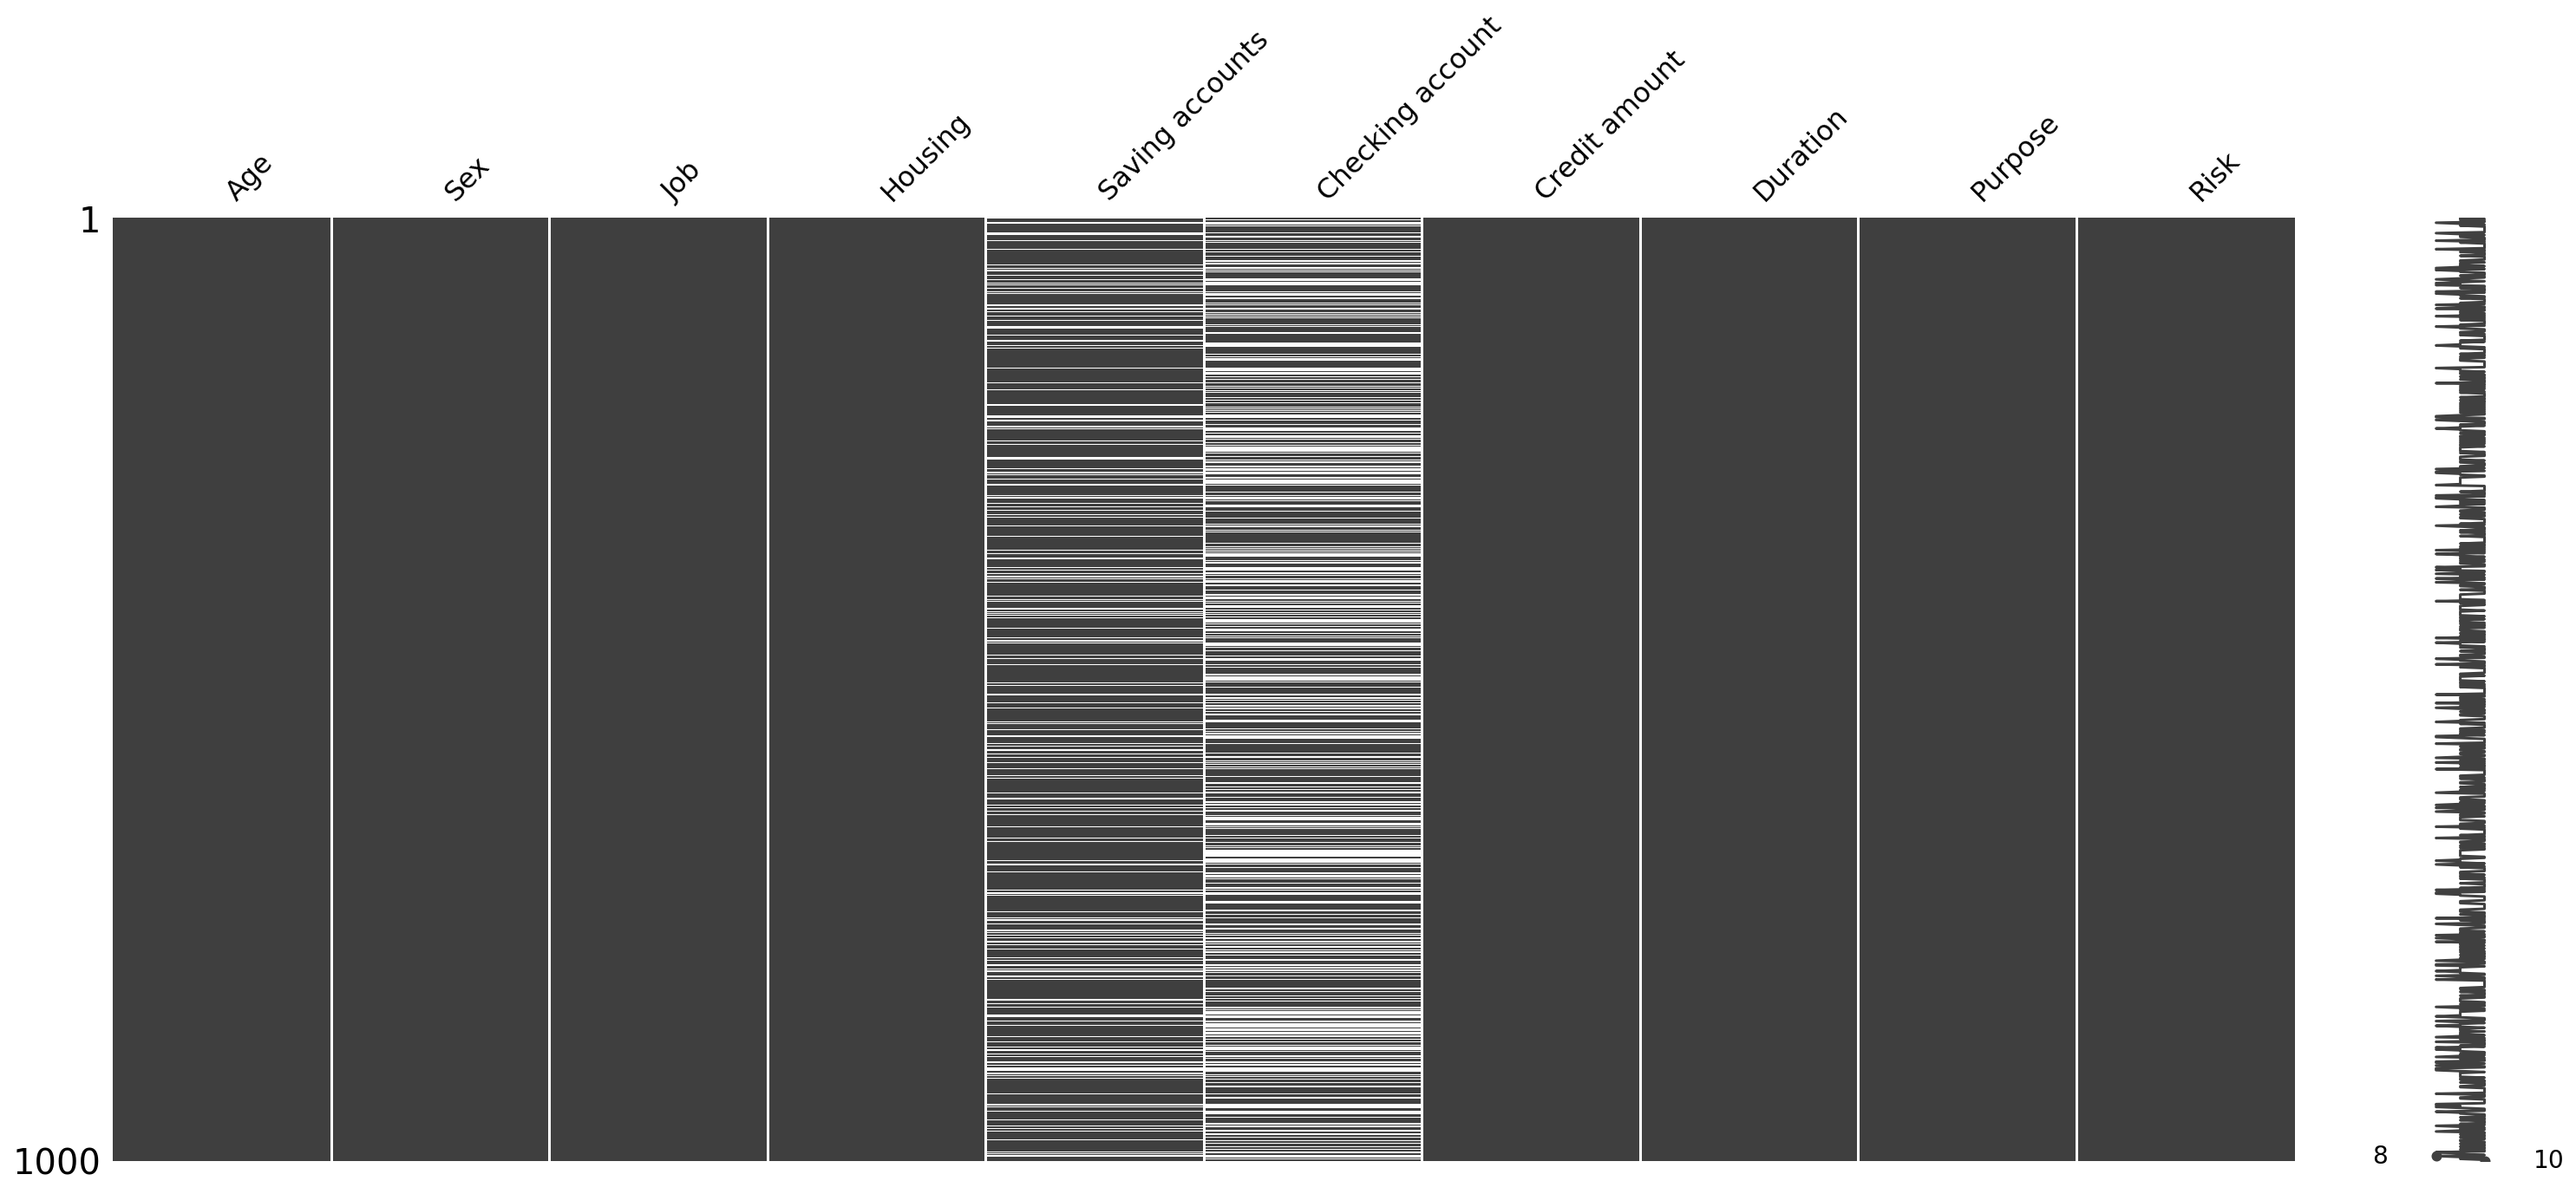

In [25]:
# EKSİKLİKLERİ GÖZLEMLEYELİM
msno.matrix(df)
plt.show()

In [26]:
label_columns = ["Sex", "Risk"]
label_encoder(df, label_columns)  # Sex ve Risk değişkenlerini 1 ve 0 a dönüştürdük.

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,1,2,own,NaN,little,1169,6,radio/TV,1
1,22,0,2,own,little,moderate,5951,48,radio/TV,0
2,49,1,1,own,little,NaN,2096,12,education,1
3,45,1,2,free,little,little,7882,42,furniture/equipment,1
4,53,1,2,free,little,little,4870,24,car,0
...,...,...,...,...,...,...,...,...,...,...
995,31,0,1,own,little,NaN,1736,12,furniture/equipment,1
996,40,1,3,own,little,little,3857,30,car,1
997,38,1,2,own,little,NaN,804,12,radio/TV,1
998,23,1,2,free,little,little,1845,45,radio/TV,0


In [27]:
# Aykırı gözlem var mı?  YOK
numeric_columns = df.select_dtypes(["int","float"])
has_outliers(df, numeric_columns)

[]

In [28]:
temp_cat = ["Sex", "Job", "Housing", "Saving accounts", "Checking account", "Duration", "Purpose"]
rare_analyser(df, temp_cat, "Risk", 0.5)

Sex : 2  benzersiz sınıf bulunmaktadır.
   COUNT  RATIO  TARGET_MEAN  TARGET_MEDIAN
0    310   0.31     0.648387            1.0
1    690   0.69     0.723188            1.0


Job : 4  benzersiz sınıf bulunmaktadır.
   COUNT  RATIO  TARGET_MEAN  TARGET_MEDIAN
0     22  0.022     0.681818            1.0
1    200  0.200     0.720000            1.0
2    630  0.630     0.704762            1.0
3    148  0.148     0.655405            1.0


Housing : 3  benzersiz sınıf bulunmaktadır.
      COUNT  RATIO  TARGET_MEAN  TARGET_MEDIAN
free    108  0.108     0.592593            1.0
own     713  0.713     0.739130            1.0
rent    179  0.179     0.608939            1.0


Saving accounts : 4  benzersiz sınıf bulunmaktadır.
            COUNT  RATIO  TARGET_MEAN  TARGET_MEDIAN
little        603  0.603     0.640133            1.0
moderate      103  0.103     0.669903            1.0
quite rich     63  0.063     0.825397            1.0
rich           48  0.048     0.875000            1.0


Checking ac

In [29]:
# rare durations - Nadir Süreler 
# Duration değişkeninde gözlemlediğimiz benzersiz değerlerin sayıları 1  ve 2 olanları aldık.
nums = [16, 22, 26, 40, 47, 54, 72]
for i in nums:
    df = df.loc[~(df["Duration"] == i)] # benzersiz değerlerin sayısı 2 den büyük olanlardan df oluşturduk

# MANTIĞINI ANLAMADIM NEDEN BÖYLE BİR ŞEY YAPIYOR?
df.loc[df["Duration"] == 5, ["Duration"]] = 4 # değeri 5 olan gözleme 4 değerini attık
df.loc[df["Duration"] == 7, ["Duration"]] = 4
df.loc[df["Duration"] == 11, ["Duration"]] = 4

df.loc[df["Duration"] == 8, ["Duration"]] = 6
df.loc[df["Duration"] == 10, ["Duration"]] = 6

df.loc[df["Duration"] == 12, ["Duration"]] = 9

df.loc[df["Duration"] == 24, ["Duration"]] = 21

df.loc[df["Duration"] == 28, ["Duration"]] = 27
df.loc[df["Duration"] == 30, ["Duration"]] = 27
df.loc[df["Duration"] == 33, ["Duration"]] = 27

df.loc[df["Duration"] == 42, ["Duration"]] = 39

df.loc[df["Purpose"] == "domestic appliances", ["Purpose"]] = "furniture/equipment"

rare_analyser(df, temp_cat, "Risk", 0.5)


Sex : 2  benzersiz sınıf bulunmaktadır.
   COUNT     RATIO  TARGET_MEAN  TARGET_MEDIAN
0    308  0.311111     0.646104            1.0
1    682  0.688889     0.725806            1.0


Job : 4  benzersiz sınıf bulunmaktadır.
   COUNT     RATIO  TARGET_MEAN  TARGET_MEDIAN
0     21  0.021212     0.666667            1.0
1    198  0.200000     0.717172            1.0
2    623  0.629293     0.707865            1.0
3    148  0.149495     0.655405            1.0


Housing : 3  benzersiz sınıf bulunmaktadır.
      COUNT     RATIO  TARGET_MEAN  TARGET_MEDIAN
free    107  0.108081     0.588785            1.0
own     707  0.714141     0.739745            1.0
rent    176  0.177778     0.613636            1.0


Saving accounts : 4  benzersiz sınıf bulunmaktadır.
            COUNT     RATIO  TARGET_MEAN  TARGET_MEDIAN
little        597  0.603030     0.641541            1.0
moderate      102  0.103030     0.676471            1.0
quite rich     62  0.062626     0.822581            1.0
rich           48 

In [30]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,1,2,own,NaN,little,1169,6,radio/TV,1
1,22,0,2,own,little,moderate,5951,48,radio/TV,0
2,49,1,1,own,little,NaN,2096,9,education,1
3,45,1,2,free,little,little,7882,39,furniture/equipment,1
4,53,1,2,free,little,little,4870,21,car,0


In [31]:
# Age değişkeninden Age_Range kategorik değişkenini türetelim.

bins = [18,25,40,55,100]
names = ["Young","Adult","Mature","Old"]

df["Age_Range"] = pd.cut(df["Age"], bins, labels=names)

# Pandas cut(), dizi öğelerini farklı kutulara ayırmak için kullanılır.
# bins: segmentasyon için bin kenarlarını tanımlar.
# labels: Döndürülen bölmeler için etiketleri belirtir. 

In [32]:
# Duration(Süre) değişkeninden Year değişkeni türetiliyor.
# Böylece kaç yıllık müşteri olduğu anlaşılacak.

df["Year"] = str(df["Duration"])

df.loc[df["Duration"] <= 12, "Year"] = "0-1 year"
df.loc[(df["Duration"] > 12) & (df["Duration"] <= 24), "Year"] = "1-2 Year"
df.loc[(df["Duration"] > 24) & (df["Duration"] <= 36), "Year"] = "2-3 year"
df.loc[(df["Duration"] > 36) & (df["Duration"] <= 48), "Year"] = "3-4 year"
df.loc[(df["Duration"] > 48) & (df["Duration"] <= 60), "Year"] = "4-5 year"
df.loc[(df["Duration"] > 60) & (df["Duration"] <= 72), "Year"] = "5-6 year"
df.loc[(df["Duration"] > 72) & (df["Duration"] <= 84), "Year"] = "6-7 year"

In [33]:
# Status değişkeni Credit amount değişkeninden türeyen, ekonomik sınıfı simgeleyen değişken.
"""
qcut , temel alınan verileri eşit büyüklükteki kutulara bölmeye çalıştığı
anlamına gelir . İşlev, bölmelerin gerçek sayısal kenarlarına değil, 
verilerin dağılımına dayalı yüzdelikler kullanarak bölmeleri tanımlar.
"""
df["Status"] = pd.qcut(df["Credit amount"], 4, labels = ["poor","mid","upper","rich"])


**!!! Kutularınızdaki öğelerin eşit dağılımını istiyorsanız, öğesini kullanın qcut . Kendi sayısal kutu aralıklarınızı tanımlamak istiyorsanız, cut .**

In [34]:
abc = df.copy()
df = abc.copy()

In [35]:
# Eksik değerler dolduruluyor. (Saving accounts ve Checking account)
df["Saving accounts"] = df.groupby(["Sex","Risk","Age_Range"])["Saving accounts"].transform(lambda x: x.fillna(x.mode()[0]))

df["Checking account"] = df.groupby(["Sex","Risk","Age_Range"])["Checking account"].transform(lambda x: x.fillna(x.mode()[0]))

In [36]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Age_Range,Year,Status
0,67,1,2,own,little,little,1169,6,radio/TV,1,Old,0-1 year,poor
1,22,0,2,own,little,moderate,5951,48,radio/TV,0,Young,3-4 year,rich
2,49,1,1,own,little,little,2096,9,education,1,Mature,0-1 year,mid
3,45,1,2,free,little,little,7882,39,furniture/equipment,1,Mature,3-4 year,rich
4,53,1,2,free,little,little,4870,21,car,0,Mature,1-2 Year,rich


In [37]:
rare_analyser(df, temp_cat, "Risk", 0.5)

Sex : 2  benzersiz sınıf bulunmaktadır.
   COUNT     RATIO  TARGET_MEAN  TARGET_MEDIAN
0    308  0.311111     0.646104            1.0
1    682  0.688889     0.725806            1.0


Job : 4  benzersiz sınıf bulunmaktadır.
   COUNT     RATIO  TARGET_MEAN  TARGET_MEDIAN
0     21  0.021212     0.666667            1.0
1    198  0.200000     0.717172            1.0
2    623  0.629293     0.707865            1.0
3    148  0.149495     0.655405            1.0


Housing : 3  benzersiz sınıf bulunmaktadır.
      COUNT     RATIO  TARGET_MEAN  TARGET_MEDIAN
free    107  0.108081     0.588785            1.0
own     707  0.714141     0.739745            1.0
rent    176  0.177778     0.613636            1.0


Saving accounts : 4  benzersiz sınıf bulunmaktadır.
            COUNT     RATIO  TARGET_MEAN  TARGET_MEDIAN
little        778  0.785859     0.683805            1.0
moderate      102  0.103030     0.676471            1.0
quite rich     62  0.062626     0.822581            1.0
rich           48 

In [38]:
categorical_columns = ["Sex", "Housing", "Saving accounts", "Checking account", "Purpose", "Age_Range", "Year"]

numeric_columns = ["Age", "Job", "Credit amount", "Duration"]

one_hot_columns = ["Housing", "Saving accounts", "Checking account", "Purpose", "Age_Range", "Year", "Status"]

df, one_hot_encodeds = one_hot_encoder(df, one_hot_columns)

In [39]:
df.head()

,Age,Sex,Job,Credit amount,Duration,Risk,Housing_free,Housing_own,Housing_rent,Saving accounts_little,...,Age_Range_Old,Year_0-1 year,Year_1-2 Year,Year_2-3 year,Year_3-4 year,Year_4-5 year,Status_poor,Status_mid,Status_upper,Status_rich
0,67,1,2,1169,6,1,0,1,0,1,...,1,1,0,0,0,0,1,0,0,0
1,22,0,2,5951,48,0,0,1,0,1,...,0,0,0,0,1,0,0,0,0,1
2,49,1,1,2096,9,1,0,1,0,1,...,0,1,0,0,0,0,0,1,0,0
3,45,1,2,7882,39,1,1,0,0,1,...,0,0,0,0,1,0,0,0,0,1
4,53,1,2,4870,21,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,1


In [40]:
X = df.drop("Risk", axis=1)
y = np.ravel(df["Risk"])
# np.ravel : Girdinin öğelerini içeren 1 boyutlu bir dizi döndürülür. Bir kopya yalnızca gerektiğinde yapılır

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=357)

X_train.head()

,Age,Sex,Job,Credit amount,Duration,Housing_free,Housing_own,Housing_rent,Saving accounts_little,Saving accounts_moderate,...,Age_Range_Old,Year_0-1 year,Year_1-2 Year,Year_2-3 year,Year_3-4 year,Year_4-5 year,Status_poor,Status_mid,Status_upper,Status_rich
51,30,1,3,5965,27,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,1
208,21,1,1,6568,21,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,1
195,34,0,3,1501,9,0,1,0,1,0,...,0,1,0,0,0,0,0,1,0,0
241,51,1,2,1595,6,0,1,0,1,0,...,0,1,0,0,0,0,0,1,0,0
714,27,1,3,14027,60,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,1



* n_estimators : Tahminleri için, Rastgele Orman içinde inşa etmek istediğimiz ağaç sayısı.
* max_features : En iyi bölünme bulunurken göz önüne alınan maximum özellik sayısı.
* max_depth : Ağacın derinliğini belirler. Overfitting ile baş etmek için önerilir. ağacın kökü ve yapraklar arasındaki max bağlantı sayısı. Küçük olmalı
* min_samples_split : Bir bölünmenin gerçekleşmesi için veride bulunması gereken min örnek sayısını ayarlar


In [41]:
rf_params = {"max_depth": [3, 5, 8],
             "max_features": [8, 15, 25],
             "n_estimators": [200, 500, 1000],
             "min_samples_split": [2, 5, 10]}

lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [200, 500, 1000],
               "max_depth": [3, 5, 8],
               "colsample_bytree": [1, 0.8, 0.5]}

xgb_params = {"learning_rate": [0.1, 0.01],
              "max_depth": [3, 5, 8],
              "n_estimators": [200, 500, 1000],
              "colsample_bytree": [0.7, 1]}

rf = RandomForestClassifier(random_state=357)
lgbm = LGBMClassifier(random_state=357)
xgb = XGBClassifier(random_state=357)

gs_cv_rf = GridSearchCV(rf,
                        rf_params,
                        cv=10,
                        n_jobs=-1,
                        verbose=2).fit(X_train, y_train)

gs_cv_lgbm = GridSearchCV(lgbm,
                          lgbm_params,
                          cv=10,
                          n_jobs=-1,
                          verbose=2).fit(X_train, y_train)

gs_cv_xgb = GridSearchCV(xgb,
                         xgb_params,
                         cv=10,
                         n_jobs=-1,
                         verbose=2).fit(X_train, y_train)

rf_tuned = RandomForestClassifier(**gs_cv_rf.best_params_, random_state=357).fit(X_train, y_train)

lgbm_tuned = LGBMClassifier(**gs_cv_lgbm.best_params_, random_state=357).fit(X_train, y_train)

xgb_tuned = XGBClassifier(**gs_cv_xgb.best_params_, random_state=357).fit(X_train, y_train)

Fitting 10 folds for each of 81 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  2.3min finished


Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:   15.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  1.8min finished


[15:29:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [42]:
# Sonuçlar
models = [("RF", rf_tuned),
          ("LGBM", lgbm_tuned),
          ("XGB", xgb_tuned)]

results = []
names = []

for name, model in models:
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    msg = "%s: (%f)" % (name, acc)
    print(msg)

RF: (0.712121)
LGBM: (0.732323)
XGB: (0.737374)
